In [1]:
from keras.models import Model
from keras.layers.core import Dense, Reshape, Lambda
from keras.layers import Input, Embedding, concatenate, Multiply
from keras import backend as K
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras import preprocessing
from keras.regularizers import l2
import random
from keras.layers.advanced_activations import LeakyReLU
import keras
import time
import talos

Using TensorFlow backend.


In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7124118012872547140
]


In [2]:
#df = pd.read_csv('/Users/BharathiSrinivasan/Documents/GitHub/Thesis/merged_data.csv')
folder = 'C:\\Users\\Pascal\\Documents\\GitHub\\instacart-market-basket-analysis\\'

In [3]:
#df_big = pd.read_csv(folder + 'merged_data.csv')

In [4]:
#Sample orders of n customer
def data_nusers(df, n):
    unique_users = df.user_id.unique()
    i = 0
    df_nusers = pd.DataFrame()  
    for user in unique_users:
        df_nusers = df_nusers.append(df[df.user_id == user])
        i +=1
        if (i == n):
            break
    return pd.DataFrame(df_nusers)

In [77]:
df = pd.read_csv(folder + 'merged_data.csv')

In [78]:
df_use = data_nusers(df, 1000)

In [80]:
df_use.to_csv(folder+'data1000.csv', index=False)

In [82]:
# Number of product IDs available
N_products = df_use['product_id'].nunique()
N_shoppers = df_use['user_id'].nunique()

print(N_products,N_shoppers )

In [83]:
EMBEDDING_COLUMNS = ["user_id", "product_id"]

In [84]:
#Helper to index columns before embeddings
def val2idx(df, cols):
    val_types = dict()
    for c in cols:
        val_types[c] = df[c].unique()

    val_to_idx = dict()
    for k, v in val_types.items():
        val_to_idx[k] = {o: i for i, o in enumerate(val_types[k])}

    for k, v in val_to_idx.items():
        df[k] = df[k].apply(lambda x: v[x]+1)

    unique_vals = dict()
    for c in cols:
        unique_vals[c] = df[c].nunique()

    return df, unique_vals

In [86]:
df_deep, unique_vals = val2idx(df_use, EMBEDDING_COLUMNS)

In [87]:
df_deep.shape

(346377, 13)

In [88]:
def first_prod(order):
    for _,row in order.iterrows():
        if row['add_to_cart_order']==1:
            return row['product_id']

In [89]:
def next_prod(order):
    for _,row in order.iterrows():
        if row['add_to_cart_order']==2:
            return row['product_id']

In [90]:
def create_basket(order):
    order['product_id']= order['product_id'].astype(str)
    
    basket = []
    for _,row in order.iterrows():
        if row['add_to_cart_order']!=1:
            basket.append(row['product_id'])
    #basket = random.shuffle(basket)
    return basket

In [91]:
def create_basket_by_order(order,order_id_list, N_products):
    names = []
    for col in range(N_products):
        names.append('col_' + str(col))
    basket_df = pd.DataFrame(columns=names, index = order_id_list)
    
    for i in order.index:
        list_items = order.get_value(i, 'basket')
        for val in list_items:
            basket_df.loc[i,'col_'+str(val)] = 1
    basket_df.fillna(0, inplace=True)
    
    return basket_df

In [94]:
'''
from scipy.sparse import csr_matrix

# Group interactions
order_product = df_deep.groupby(by=['order_id','product_id']).apply(lambda x: 1).to_dict() 

# Number of different Users / Locations
N_orders = df_deep.order_id.nunique()
N_products = df_deep.product_id.nunique()

# Build Rating matrix
row, col = zip(*(order_product.keys())) #row-> orders,  col-> products
map_o = dict(zip(df_deep['order_id'].unique(),range(N_orders)))
map_p = dict(zip(df_deep['product_id'].unique(),range(N_products)))
row_idx = [map_o[o] for o in row]
col_idx = [map_p[p] for p in col]
data = np.array(order_product.values)
basket_matrix = csr_matrix((data, (row_idx, col_idx)), shape=(N_orders,N_products))
'''

"\nfrom scipy.sparse import csr_matrix\n\n# Group interactions\norder_product = df_deep.groupby(by=['order_id','product_id']).apply(lambda x: 1).to_dict() \n\n# Number of different Users / Locations\nN_orders = df_deep.order_id.nunique()\nN_products = df_deep.product_id.nunique()\n\n# Build Rating matrix\nrow, col = zip(*(order_product.keys())) #row-> orders,  col-> products\nmap_o = dict(zip(df_deep['order_id'].unique(),range(N_orders)))\nmap_p = dict(zip(df_deep['product_id'].unique(),range(N_products)))\nrow_idx = [map_o[o] for o in row]\ncol_idx = [map_p[p] for p in col]\ndata = np.array(order_product.values)\nbasket_matrix = csr_matrix((data, (row_idx, col_idx)), shape=(N_orders,N_products))\n"

In [95]:
def transform_data_for_embedding(df):
    first = df.groupby(['order_id']).apply(first_prod)
    next_product = df.groupby(['order_id']).apply(lambda x:next_prod(x))
    basket =df.groupby(['order_id', 'product_id']).size().unstack(fill_value=0)
    transform_df = pd.DataFrame(first, columns = ['first_prod'])
    transform_df['next_product']= next_product.values
    transform_df.reset_index(inplace=True)

    # Number of product IDs available
    N_products = df['product_id'].nunique()
    N_shoppers = df['user_id'].nunique()

    return transform_df, basket, N_products, N_shoppers

In [105]:
%time
df1, basket, N_products, N_shoppers = transform_data_for_embedding(df_deep)

Wall time: 0 ns


In [106]:
basket.head()

product_id,1,2,3,4,5,6,7,8,9,10,...,19030,19031,19032,19033,19034,19035,19036,19037,19038,19039
order_id,,,,,,,,,,,,,,,,,,,,,
2,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [107]:
def create_input_for_embed_network(df, transform_df, basket, N_products):

    # Creating df with order_id, user_id, first prod, next prod, basket 
    x = df.drop_duplicates(subset=['order_id','user_id'])
    train_df = pd.merge(transform_df, x[['order_id','user_id']], how='left', on='order_id' )
    train_df.dropna(inplace=True)
    
    basket.reset_index(inplace=True)
    basket_df = pd.merge(train_df[['order_id']], basket, how='left', on ='order_id')
    basket_df.drop(['order_id'], axis=1, inplace=True)

    train_df['next_product'] = train_df['next_product'].astype('category', categories = df.product_id.unique())
    y_df = pd.get_dummies(train_df, columns = ['next_product'])
    y_df.drop(['user_id','order_id','first_prod'], axis=1, inplace=True)

    return train_df['first_prod'], train_df['user_id'], basket_df, y_df

In [108]:
time_start = time.clock()
product_in , user_in, basket_in, predicted_product = create_input_for_embed_network(df_deep, df1, basket, N_products)
time_taken = (time.clock() - time_start)

C:\Users\Pascal\Anaconda3\envs\Deep_Learning\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  


In [3]:
print(user_in.shape, product_in.shape, basket_in.shape, predicted_product.shape)

[product_tr , user_tr, basket_tr], [product_te , user_te, basket_te], predicted_tr, predicted_te = train_test_split([product_in , user_in, basket_in], predicted_product, test_size=0.20,\
                                                                    random_state=42)

NameError: name 'user_in' is not defined

In [110]:
# Integer IDs representing 1-hot encodings
prior_in = Input(shape=(1,))
shopper_in = Input(shape=(1,))

# Dense N-hot encoding for candidate products
candidates_in = Input(shape=(N_products,))

# Embeddings
prior = Embedding(N_products+1, 10)(prior_in)
shopper = Embedding(N_shoppers+1, 10)(shopper_in)

# Reshape and merge all embeddings together
reshape = Reshape(target_shape=(10,))
combined = keras.layers.concatenate([reshape(prior), reshape(shopper)])

# Hidden layers
#hidden_1 = Dense(1024, activation='relu',W_regularizer=l2(0.02))(combined)
#hidden_2 = Dense(512, activation='relu',W_regularizer=l2(0.02))(hidden_1)
hidden_3 = Dense(100, activation='relu')(combined)
#LR1 = LeakyReLU(alpha=0.1)(hidden_3)
hidden_4 = Dense(1, activation='relu')(hidden_3)

# Final 'fan-out' into the space of future products
final = Dense(N_products, activation='relu')(hidden_4)
#LR_final = LeakyReLU(alpha=0.1)(final)

# Ensure we do not overflow when we exponentiate
final = Lambda(lambda x: x - K.max(x))(final)

# Masked soft-max using Lambda and merge-multiplication
exponentiate = Lambda(lambda x: K.exp(x))(final)
masked = keras.layers.multiply([exponentiate, candidates_in])
predicted = Lambda(lambda x: x / K.sum(x))(masked)

# Compile with categorical crossentropy and adam
mdl = Model(input=[prior_in , shopper_in, candidates_in],
            output=predicted)
mdl.compile(loss='categorical_crossentropy', 
            optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])),
            metrics=['accuracy'])

C:\Users\Pascal\Anaconda3\envs\Deep_Learning\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("la...)`


In [113]:
history = mdl.fit([product_in , user_in, basket_in], predicted_product, batch_size= params['batch_size'], epochs=params['epochs'], verbose=0)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [4]:
def embeddings_model(prior_in , shopper_in, candidates_in, predicted,\
                     prior_val=product_te , shopper_val=user_te, candidates_val=basket_te,\
                     predicted_val=predicted_te, params):
    # Integer IDs representing 1-hot encodings
    prior_in = Input(shape=(1,))
    shopper_in = Input(shape=(1,))

    # Dense N-hot encoding for candidate products
    candidates_in = Input(shape=(N_products,))

    # Embeddings
    prior = Embedding(N_products+1, 10)(prior_in)
    shopper = Embedding(N_shoppers+1, 10)(shopper_in)

    # Reshape and merge all embeddings together
    reshape = Reshape(target_shape=(10,))
    combined = keras.layers.concatenate([reshape(prior), reshape(shopper)])

    # Hidden layers
    hidden_1 = Dense(params['first_neuron'], activation=params['activation'])(combined)
    hidden_2 = Dense(params['second_neuron'], activation=params['activation'])(hidden_1)

    # Final 'fan-out' into the space of future products
    final = Dense(N_products, activation='relu')(hidden_4)

    # Ensure we do not overflow when we exponentiate
    final = Lambda(lambda x: x - K.max(x))(final)

    # Masked soft-max using Lambda and merge-multiplication
    exponentiate = Lambda(lambda x: K.exp(x))(final)
    masked = keras.layers.multiply([exponentiate, candidates_in])
    predicted = Lambda(lambda x: x / K.sum(x))(masked)

    # Compile with categorical crossentropy and adam
    mdl = Model(input=[prior_in , shopper_in, candidates_in],
            output=predicted)
    mdl.compile(loss='categorical_crossentropy',\
            optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])),
            metrics=['accuracy'])
    
    out = model.fit([prior_in , shopper_in, candidates_in], predicted,batch_size=params['batch_size'],
                    epochs=params['epochs'],
                    verbose=0,
                    validation_data=[[product_val , user_val, basket_val], predicted_val])
    
    return out, mdl

SyntaxError: non-default argument follows default argument (<ipython-input-4-f9108a938ced>, line 1)

In [111]:
p = {'lr': (0.1, 1, 10),
     'first_neuron':[512, 256, 128],
     'second_neuron':[256, 128, 64],
     'batch_size': [100, 1000, 10000],
     'epochs': [25, 50, 100],
     'dropout': (0, 0.10, 0.2),
     'optimizer': [Adam, Nadam],
     'loss': ['categorical_crossentropy'],
     'activation': ['relu', 'softplus','tanh']}

In [ ]:
h = ta.Scan([product_tr , user_tr, basket_tr], predicted_tr, params=p,
            model=embeddings_model,
            dataset_name='instacrt',
            experiment_no='1',
            grid_downsample=.01)

In [118]:
model_json = mdl.to_json()
with open("NN_embed_model.json", "w") as json_file:
    json_file.write(model_json)
    # serialize weights to HDF5
mdl.save_weights("NN_embed_model.h5")
print("Saved model to disk")

Saved model to disk


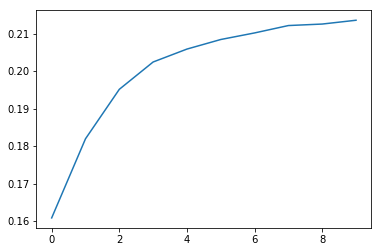

In [117]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['acc'])
plt.show()